# Feature processing

In this notebook we will explore different feature processing methods, 
1. Feature selection 
> Dropping highly correlated features
2. Feature dimensionality reduction 
> Methods like PCA ([Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis)) reduces the dimensionality of the problem 
3. Feature scaling
> Features whose ranges differ need to be scaled

Our data is well behaved enough to not require most of the above but in this notebook we will compare the cross-validated accuracy of features with and without any processing. 

## First, let us plot the correlation plot of our dataframe

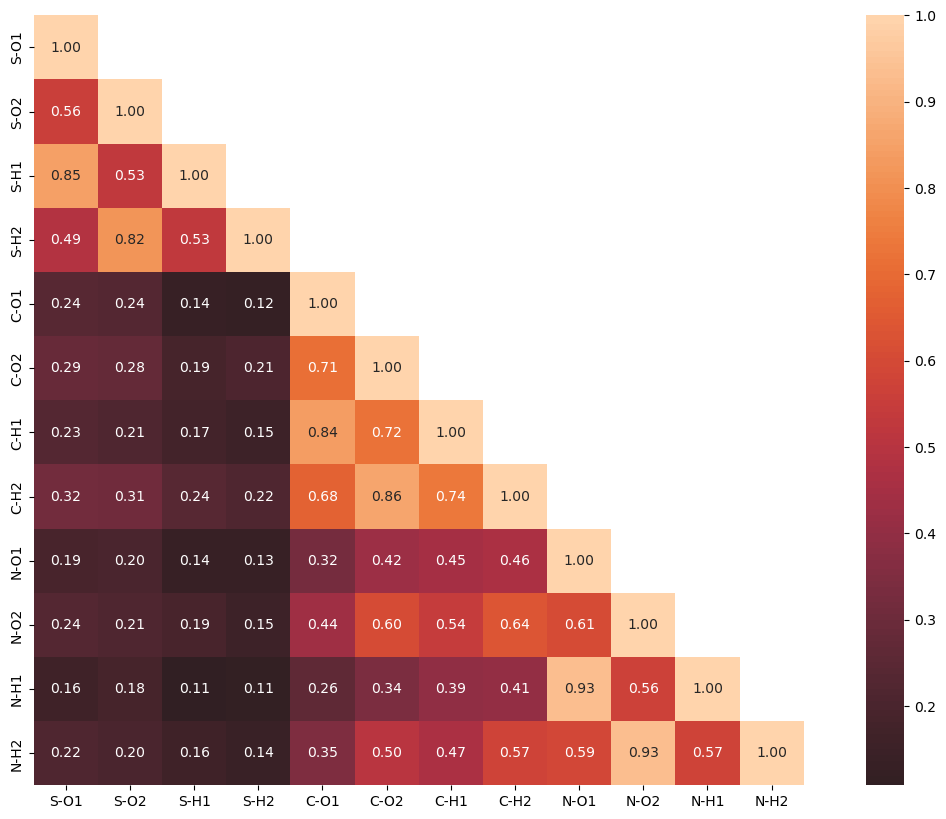

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
import warnings

warnings.filterwarnings('ignore')

df_AIMD = pd.read_csv("Dist_AIMD.csv") 
df_MD = pd.read_csv('Dist_MD.csv')
df_fin = pd.concat([df_AIMD, df_MD])

df_shuffle = shuffle(df_fin, random_state=0)

# Pandas has the method called corr which calculates correlation between all columns 
corr = df_shuffle.iloc[:,2:].corr()

# Create a mask for the lower-triangular block of correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool), k = 1) # Drop the k=1 to drop the diagonal 

# Plot the heatmap
plt.figure(figsize=(16, 10))

sns.heatmap(corr, mask=mask, center=0, annot=True,
            fmt='.2f', square=True)

plt.show()

In [2]:
# Now to drop highly correlated features like one of each from {N-O1, N-H1} and {N-O2, N-H2}

# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones_like(corr, dtype=bool), k=1))
print(upper)

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
print(to_drop)

      S-O1      S-O2      S-H1      S-H2      C-O1      C-O2      C-H1  \
S-O1   NaN  0.560643  0.845538  0.487462  0.238965  0.285964  0.233494   
S-O2   NaN       NaN  0.525662  0.816516  0.235821  0.281218  0.212922   
S-H1   NaN       NaN       NaN  0.531748  0.135108  0.187821  0.174350   
S-H2   NaN       NaN       NaN       NaN  0.123907  0.206337  0.153635   
C-O1   NaN       NaN       NaN       NaN       NaN  0.713991  0.839090   
C-O2   NaN       NaN       NaN       NaN       NaN       NaN  0.722133   
C-H1   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
C-H2   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
N-O1   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
N-O2   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
N-H1   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
N-H2   NaN       NaN       NaN       NaN       NaN       NaN       NaN   

          C-H2      N-O1      N-O2   

In [3]:
# A function that does essentially the same thing but prints more info
def corr_cols(corr_matrix, threshold):
    
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])
    return drop_cols

print(corr_cols(corr, 0.85))

C-H2 | C-O2 | 0.86
N-H1 | N-O1 | 0.93
N-H2 | N-O2 | 0.93
['C-H2', 'N-H1', 'N-H2']


In [4]:
# Let's drop the correlate columns

df_drop = df_shuffle.drop(columns=to_drop)

df_drop.head()

,Class,ClassName,S-O1,S-O2,S-H1,S-H2,C-O1,C-O2,C-H1,N-O1,N-O2
200,0,MD,3.058644,3.268839,2.127982,2.398241,2.880752,3.231719,2.107106,2.722132,2.823587
170,1,AIMD,3.249995,3.263349,2.265893,2.361130,3.094923,3.190536,2.335263,2.854410,2.938808
15,0,MD,2.914829,2.965123,2.012212,2.158510,2.984337,3.054808,2.247004,2.715118,2.766487
181,0,MD,2.874340,3.234227,1.969793,2.422937,3.453376,3.579303,2.573053,2.732942,2.971228
99,0,MD,2.998400,3.009045,2.113534,2.155761,3.038301,3.043577,2.177829,2.713162,2.785390


## Since we have determined the "best" model for several ML algorithms in previous notebooks, let's define them and compare the cross validated accuracies

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate


# best n_neighbors was 12 for O dataset and 8 for H
knn = KNeighborsClassifier(n_neighbors=10) 

# C = 100 was stable for both sets
lr = LogisticRegression(C=100, random_state=0)

# 3 different kernels had different performances, let's fix gamma ~ 1/6
svc_lin = SVC(kernel='linear', C=1.0, random_state=0)
svc_poly = SVC(kernel='poly', degree=3, C=1.0, gamma=0.17, random_state=0)
svc_rbf = SVC(kernel='rbf', C=1.0, gamma=0.17, random_state=0)

# DecisionTrees are special since correlated features don't matter to them
dt = DecisionTreeClassifier(random_state=0, max_depth=4, min_samples_leaf=10)

# For NaiveBayes they matter a lot 
nb = GaussianNB()

# RandomForest and GBC showed signs of overfitting but had high test scores too 
rf = RandomForestClassifier(random_state=0, max_depth=4, max_features='auto', n_estimators=10)
gbc = GradientBoostingClassifier(random_state=0, learning_rate=0.25, max_depth=3, min_samples_split=8, n_estimators=25)

# MLP showed issues with learning 
mlp = MLPClassifier(solver='lbfgs', activation='logistic', alpha = 0.0005, random_state=0, 
                        hidden_layer_sizes=[50,50], max_iter=300)

models = [knn, lr, svc_lin, svc_poly, svc_rbf, dt, nb, rf, gbc, mlp]

def print_cross_val_scores(est, X, y, scoring, cv):
    model_name = est.__class__.__name__
    scores = cross_validate(est, X, y, scoring=scoring, cv=cv, return_train_score=True)
    
    print("Mean Training {} score of {} model with {} features: {:.2f} with standard deviation {:.3f}"
          .format(scoring, model_name, X.shape[1], np.mean(scores['train_score']), np.std(scores['train_score'])))
    
    print("Mean Test {} score of {} model with {} features: {:.2f} with standard deviation {:.3f}\n"
          .format(scoring, model_name, X.shape[1], np.mean(scores['test_score']), np.std(scores['test_score'])))
    
    return scores

## Let's do it for all the 12 features first

In [6]:
# Divide the shuffled dataframe into features and target
X = df_shuffle.iloc[:,2:]
y = df_shuffle['Class']

dict_12 = {}
for model in models:
    score = print_cross_val_scores(model, X, y, 'accuracy', 5)
    dict_12[str(model)] = score

Mean Training accuracy score of KNeighborsClassifier model with 12 features: 0.93 with standard deviation 0.005
Mean Test accuracy score of KNeighborsClassifier model with 12 features: 0.92 with standard deviation 0.020

Mean Training accuracy score of LogisticRegression model with 12 features: 0.94 with standard deviation 0.006
Mean Test accuracy score of LogisticRegression model with 12 features: 0.92 with standard deviation 0.035

Mean Training accuracy score of SVC model with 12 features: 0.94 with standard deviation 0.008
Mean Test accuracy score of SVC model with 12 features: 0.93 with standard deviation 0.035

Mean Training accuracy score of SVC model with 12 features: 0.94 with standard deviation 0.004
Mean Test accuracy score of SVC model with 12 features: 0.93 with standard deviation 0.025

Mean Training accuracy score of SVC model with 12 features: 0.93 with standard deviation 0.008
Mean Test accuracy score of SVC model with 12 features: 0.93 with standard deviation 0.031

M

## Now for the dataset without correlated features

In [7]:
# Divide the dataframe without correlated features into features and target
X = df_drop.iloc[:,2:]
y = df_drop['Class']

dict_9 = {}
for model in models:
    score = print_cross_val_scores(model, X, y, 'accuracy', 5)
    dict_9[str(model)] = score

Mean Training accuracy score of KNeighborsClassifier model with 9 features: 0.91 with standard deviation 0.009
Mean Test accuracy score of KNeighborsClassifier model with 9 features: 0.90 with standard deviation 0.034

Mean Training accuracy score of LogisticRegression model with 9 features: 0.94 with standard deviation 0.005
Mean Test accuracy score of LogisticRegression model with 9 features: 0.91 with standard deviation 0.044

Mean Training accuracy score of SVC model with 9 features: 0.92 with standard deviation 0.007
Mean Test accuracy score of SVC model with 9 features: 0.92 with standard deviation 0.023

Mean Training accuracy score of SVC model with 9 features: 0.94 with standard deviation 0.002
Mean Test accuracy score of SVC model with 9 features: 0.92 with standard deviation 0.028

Mean Training accuracy score of SVC model with 9 features: 0.92 with standard deviation 0.004
Mean Test accuracy score of SVC model with 9 features: 0.92 with standard deviation 0.019

Mean Traini

## Plotting the training and test scores

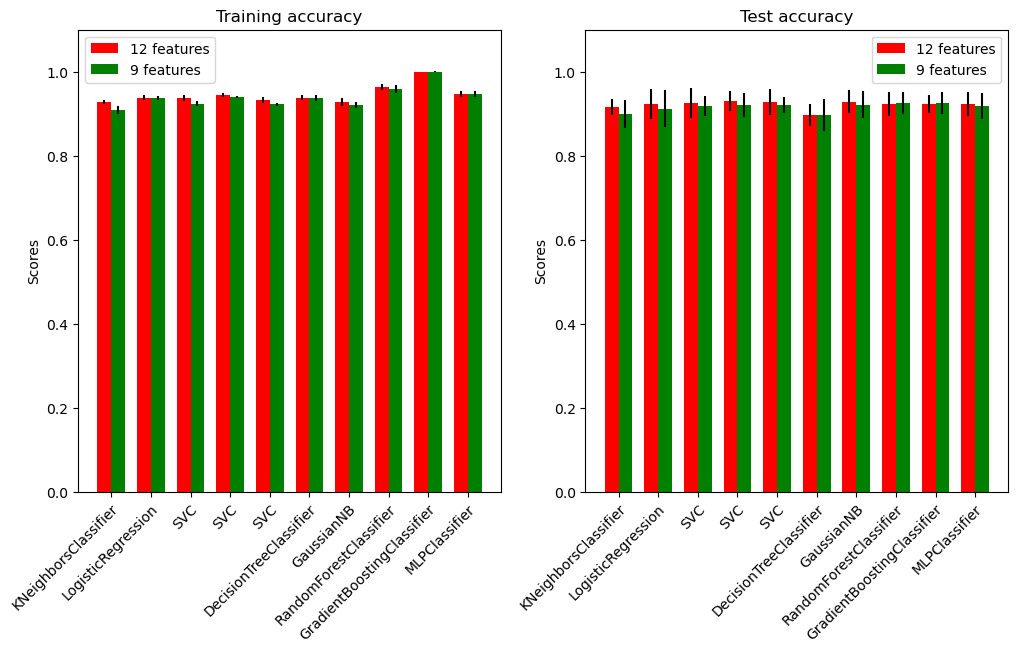

In [8]:
fig, axs = plt.subplots(1,2, figsize=(12,6))

x_vals = np.arange(len(dict_12))
x_labels = [item.split("(")[0] for item in list(dict_12.keys())]
width = 0.35

y_vals1 = [np.mean(list(dict_12.values())[i]['train_score']) for i in range(len(dict_12))]
y_err1 = [np.std(list(dict_12.values())[i]['train_score']) for i in range(len(dict_12))]

y_vals2 = [np.mean(list(dict_9.values())[i]['train_score']) for i in range(len(dict_9))]
y_err2 = [np.std(list(dict_9.values())[i]['train_score']) for i in range(len(dict_9))]

axs[0].set_title("Training accuracy")
axs[0].bar(x_vals-width/2, y_vals1, yerr=y_err1, width=width, lw=0, color='red', label='12 features')
axs[0].bar(x_vals+width/2, y_vals2, yerr=y_err2, width=width, lw=0, color='green', label='9 features')


y_vals3 = [np.mean(list(dict_12.values())[i]['test_score']) for i in range(len(dict_12))]
y_err3 = [np.std(list(dict_12.values())[i]['test_score']) for i in range(len(dict_12))]

y_vals4 = [np.mean(list(dict_9.values())[i]['test_score']) for i in range(len(dict_9))]
y_err4 = [np.std(list(dict_9.values())[i]['test_score']) for i in range(len(dict_9))]

axs[1].set_title("Test accuracy")
axs[1].bar(x_vals-width/2, y_vals3, yerr=y_err3, width=width, lw=0, color='red', label='12 features')
axs[1].bar(x_vals+width/2, y_vals4, yerr=y_err4, width=width, lw=0, color='green', label='9 features')

for ax in axs:
    ax.set_ylabel("Scores")
    ax.set_ylim(0,1.1)
    ax.set_xticks(x_vals)
    ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')
    
    ax.legend()

The plots above show that dropping 3 features from our dataset did not affect training or test scores significantly. Our dataset was quite small, but as the data and number of features grow larger, more savings can be obtained by dropping features, with slight to negligible effects on model performance. 

# Principal Component Analysis

It is a technique mostly used for very large datasets with large number of features, making interpretibility difficult. PCA analysis can help with that by reducing the dimensionality of the features, while preserving the maximum amount of information. 

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Divide the shuffled dataframe into features and target
X = df_shuffle.iloc[:,2:]
y = df_shuffle['Class']

# Each feature is then centered (mean = 0) and with unit variance
X_norm = StandardScaler().fit_transform(X)

# Then we apply the PCA analysis and only keep 2 components
pca = PCA(n_components=2).fit(X)

X_PCA = pca.transform(X)

# print the shapes for comparison 
print("Shape of the original dataset: {}\nShape of the transformed dataset: {}".format(X.shape, X_PCA.shape))

#Print the explained variance which explains how much information can be attributed to each principal component
print(pca.explained_variance_ratio_)

Shape of the original dataset: (417, 12)
Shape of the transformed dataset: (417, 2)
[0.50500392 0.18558558]


The variance ratio array shows how much 'variance' or infomation attributed by each of the components. So, the first component is attributed 50% variance, and the second is 18%. This lets us know that only two components are not enough to represent our dataset, since we would like the sum to be around 80%.

Still, let us stick with two. 

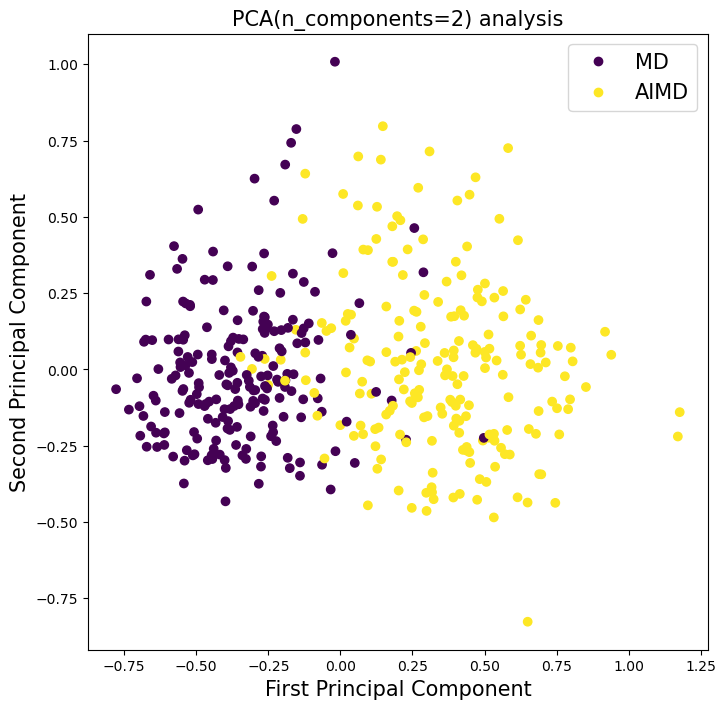

In [10]:
class_labels = ['MD', 'AIMD']

fig = plt.figure(figsize=(8,8))

plt.xlabel("First Principal Component", fontsize=15)
plt.ylabel("Second Principal Component", fontsize=15)
plt.title("PCA(n_components=2) analysis", fontsize=15)

scatter = plt.scatter(X_PCA[:,0], X_PCA[:,1], c=y)

plt.legend(handles=scatter.legend_elements()[0], labels=class_labels, fontsize=15)
plt.show()

The shape comparison shows that the number of features has been reduced to 2 from 12. The plot above shows how the classification task has simplified between only two principal componets. 

PCA can be understood as a basis transformation between the 12 component basis and the new 2 component one. We can show the contribution of each old component to the new basis.

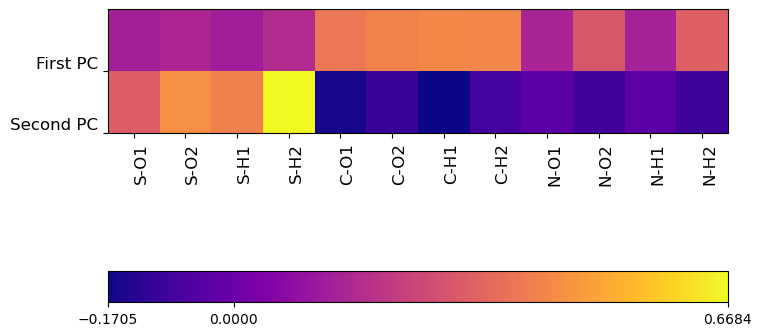

In [11]:
fig = plt.figure(figsize=(8, 4))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma', aspect='auto')
feature_names = list(X.columns)

plt.gca().set_xticks(np.arange(0, len(feature_names)));
plt.gca().set_yticks(np.arange(0.5, 2));
plt.gca().set_xticklabels(feature_names, rotation=90, ha='left', fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC'], va='bottom', fontsize=12);

plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0, pca.components_.max()], pad=0.45)

plt.show()

The image above shows the heatmap for contribution of each of the 12 features towards the first and second principal components. A couple of interesting observations,
1. The first PC seems to be made up of large contributions from C an N distances
2. The second PC is primarily made of S distances
> This reflects what we observed from the correlation heatmap where the S distances are not correlated to C an N distances at all. There is a weak correlation between C and N dtances. 

So, if the dataset is small enough to study the correlation plot, then we can guess what the composition of the PCA components might be. In other words, nothing magical is happening here. 

### PCA is not the only method which can perform dimensionality reduction. 

# Manifold learning methods

Usually applied to very high dimensional data with suble correlations which PCA cannot discern. 

Shape of the original dataset: (417, 12)
Shape of the transformed dataset: (417, 2)


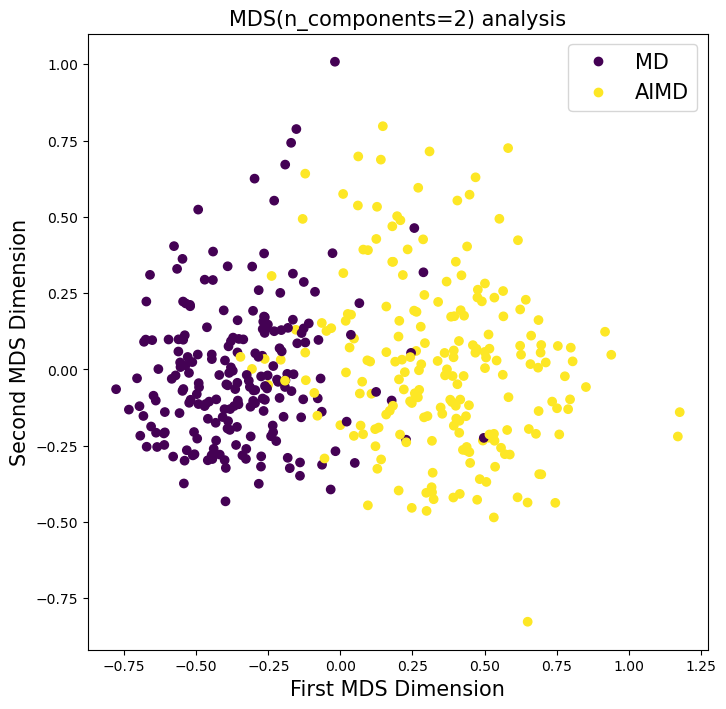

In [12]:
from sklearn.manifold import MDS # Multi-dimensional scaling

# Then we apply the MDS analysis and only keep 2 components
mds = MDS(n_components=2)

X_mds = pca.fit_transform(X)

# print the shapes for comparison 
print("Shape of the original dataset: {}\nShape of the transformed dataset: {}".format(X.shape, X_mds.shape))

fig = plt.figure(figsize=(8,8))

plt.xlabel("First MDS Dimension", fontsize=15)
plt.ylabel("Second MDS Dimension", fontsize=15)
plt.title("MDS(n_components=2) analysis", fontsize=15)

scatter = plt.scatter(X_mds[:,0], X_mds[:,1], c=y)

plt.legend(handles=scatter.legend_elements()[0], labels=class_labels, fontsize=15)
plt.show()

Not very different from the PCA plot but the issue is with out data, for which PCA analysis is enough. There are other types of dimensional reduction methods but they are expensive and we will not get into them here. 

# Feature scaling

It is important for some models that all the features are on the same scale, e.g., like the StandardScaler we saw above, for faster convergence while learning, uniform influence on all weights, etc. 

Our data is all in a very similar range and we did not have to worry about it, but if we wanted to add more features like bond angles, oxygen network sizes etc. we need to scale all the features depending on the model we use. 

Sklearn's [preprocessing](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) module has many methods for processing data, but we will explore only a few of them, 
1. StandardScaler
> Makes it so that the data has zero mean and unit variance
2. MinMaxScaler
> Can make it so the data lies between a min and max value, usually in range [0,1]

The usage varies depending on the data and model but the syntax usuallly remains the same. 

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline

#X and y are still the feature and target datasets, 
def data_scaling(est, X, y, scaler):
    #Split the data into train-test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
    # Make pipeline with the scaler and estimator
    pipe = make_pipeline(scaler, est)
    # Scale the training data
    pipe.fit(X_train, y_train)
    #Gather the scores in a dict
    score_dict = {'model' : est.__class__.__name__,
               'Scaler': scaler.__class__.__name__,
               'Train_score' : pipe.score(X_train, y_train),
               'Test_score' : pipe.score(X_test, y_test)
                }
    
    return score_dict
    
    
#define the scalers
scaler1 = StandardScaler(with_mean=True, with_std=True)
scaler2 = MinMaxScaler(feature_range=(0, 1))

#Print the accuracies for StandardScaler
d1 = []
d2 = []
for model in models:
    d1.append(data_scaling(model, X, y, scaler1))
    d2.append(data_scaling(model, X, y, scaler2))


In [14]:
df1 = pd.DataFrame(d1).set_index(['model'])
df2 = pd.DataFrame(d2).set_index(['model'])

pd.concat([df1, df2], axis=1)


,Scaler,Train_score,Test_score,Scaler,Train_score,Test_score
model,,,,,,
KNeighborsClassifier,StandardScaler,0.924925,0.916667,MinMaxScaler,0.918919,0.892857
LogisticRegression,StandardScaler,0.936937,0.952381,MinMaxScaler,0.933934,0.952381
SVC,StandardScaler,0.939940,0.940476,MinMaxScaler,0.930931,0.916667
SVC,StandardScaler,0.945946,0.904762,MinMaxScaler,0.903904,0.880952
SVC,StandardScaler,0.954955,0.928571,MinMaxScaler,0.927928,0.916667
DecisionTreeClassifier,StandardScaler,0.936937,0.940476,MinMaxScaler,0.936937,0.940476
GaussianNB,StandardScaler,0.921922,0.928571,MinMaxScaler,0.921922,0.928571
RandomForestClassifier,StandardScaler,0.960961,0.940476,MinMaxScaler,0.960961,0.940476
GradientBoostingClassifier,StandardScaler,1.000000,0.964286,MinMaxScaler,1.000000,0.964286


The dataframe shows there is no significant difference between using the scaling methods in our dataset. But, in the future if we add more features which are not as nicely distributed as the distances, then we will have to use these methods. 

Also, it is importance to note the significance of the make_pipeline method: While cross validating, using the scaler on entire dataset might cause data leakeage and to prevent that we must scale training data separately from the test data. A pipeline makes this more convenient for us. 